# **BCDI Pipeline**  
### A Notebook to Run the `BcdiPipeline` Instance  

This notebook provides a structured workflow for running a **Bragg Coherent Diffraction Imaging (BCDI) pipeline**.  

The `BcdiPipeline` class handles the entire process, including:  
- **Pre-processing** → Data preparation and corrections.  
- **Phase retrieval** → Running PyNX algorithms to reconstruct the phase.  
- **Post-processing** → Refining, analysing (get the strain!), and visualising results.  

You can provide **either**:  
- A **YAML parameter file** for full automation.  
- A **Python dictionary** for interactive control in this notebook.  


In [1]:
# import required packages
import os

import cdiutils  # core library for BCDI processing

## **General Parameters**
Here, define the key parameters for **accessing and saving data** before running the pipeline.  
- **These parameters must be set manually by the user** before execution.  
- The output data will be saved in a structured directory format based on `sample_name` and `scan`. However, you can change the directory path if you like.


> **Notes for NanoMAX users:**  
> - the `experiment_file_path` must be the path to the scan file directly! They don't use master file as at ESRF.
> - the `sample_name` is useless here, you can keep it for your results folder naming if you want.
> - the `det_calib_params` must be provided, I haven't implemented automatic reading from the scan file yet.
> - the default `detector_name` is set to `eiger500k`, but you can change it if needed (in the preprocessing step).

Enjoy!

In [ ]:
# define the key parameters (must be filled in by the user)
beamline_setup: str = "nanomax"  # example: "ID01" (provide the beamline setup)
experiment_file_path: str = (
    "raw_data/000387.h5"  # example: "/path/to/experiment/file.h5"
)
sample_name: str = "TEST"  # example: "Sample_Pt" (specify the sample name)
scan: int = 387  # example: 42 (specify the scan number)

# choose where to save the results (default: current working directory)
dump_dir = os.getcwd() + f"/results/{sample_name}/S{scan}/"

# load the parameters and parse them into the BcdiPipeline class instance
params = cdiutils.pipeline.get_params_from_variables(dir(), globals())
bcdi_pipeline = cdiutils.BcdiPipeline(params=params)

## **Pre-Processing**  

If you need to update specific parameters, you can **pass them directly** into the `preprocess` method.  

### **Main Parameters**
- `preprocess_shape` → The shape of the cropped window used throughout the processes.  
  - Can be a **tuple of 2 or 3 values**.  
  - If only **2 values**, the entire rocking curve is used.  

- `voxel_reference_methods` → A `list` (or a single value) defining how to centre the data.  
  - Can include `"com"`, `"max"`, or a `tuple` of `int` (specific voxel position).  
  - Example:
    ```python
    voxel_reference_methods = [(70, 200, 200), "com", "com"]
    ```
    - This centres a box of size `preprocess_shape` around `(70, 200, 200)`, then iteratively refines it using `"com"` (only computed within this box).
    - Useful when `"com"` fails due to artifacts or `"max"` fails due to hot pixels.  
    - Default: `["max", "com", "com"]`.  

- `rocking_angle_binning` → If you want to bin in the **rocking curve direction**, provide a binning factor (ex.: `2`).  

- `light_loading` → If `True`, loads only the **ROI of the data** based on `voxel_reference_methods` and `preprocess_output_shape`.  

- `hot_pixel_filter` → Removes isolated hot pixels. 
  - Default: `False`.  

- `background_level` → Sets the background intensity to be removed.  
  - Example: `3`.  
  - Default: `None`.  

- `hkl` → Defines the **Bragg reflection** measured to extend *d*-spacing values to the lattice parameter.  
  - Default: `[1, 1, 1]`.  


[INFO] 
*******************************************************************************
*                        Starting process: preprocess                         *
*******************************************************************************

[INFO] Additional parameters provided, will update the current dictionary of parameters.
[INFO] 
Shape already in agreement with pynx shape conventions.

[INFO] Raw detector data shape is: (181, 512, 1028).
[INFO] The preprocessing output shape is: and (181, 150, 150) will be used for the determination of the ROI dimensions.
[INFO] hot_pixel_filter requested.
[INFO] Will use defaults parameters: threshold = 1e2, kernel_size = 3 
[INFO] Method(s) employed for the voxel reference determination are ['max', 'com', 'com'].
[INFO] 
Chain centring:
	- max: (90, 273, 526), value: 96
	- com: (90, 273, 521), value: 45
	- com: (90, 273, 520), value: 46

[INFO] The reference voxel was found at (90, 273, 520) in the uncropped data frame.
The process_shap

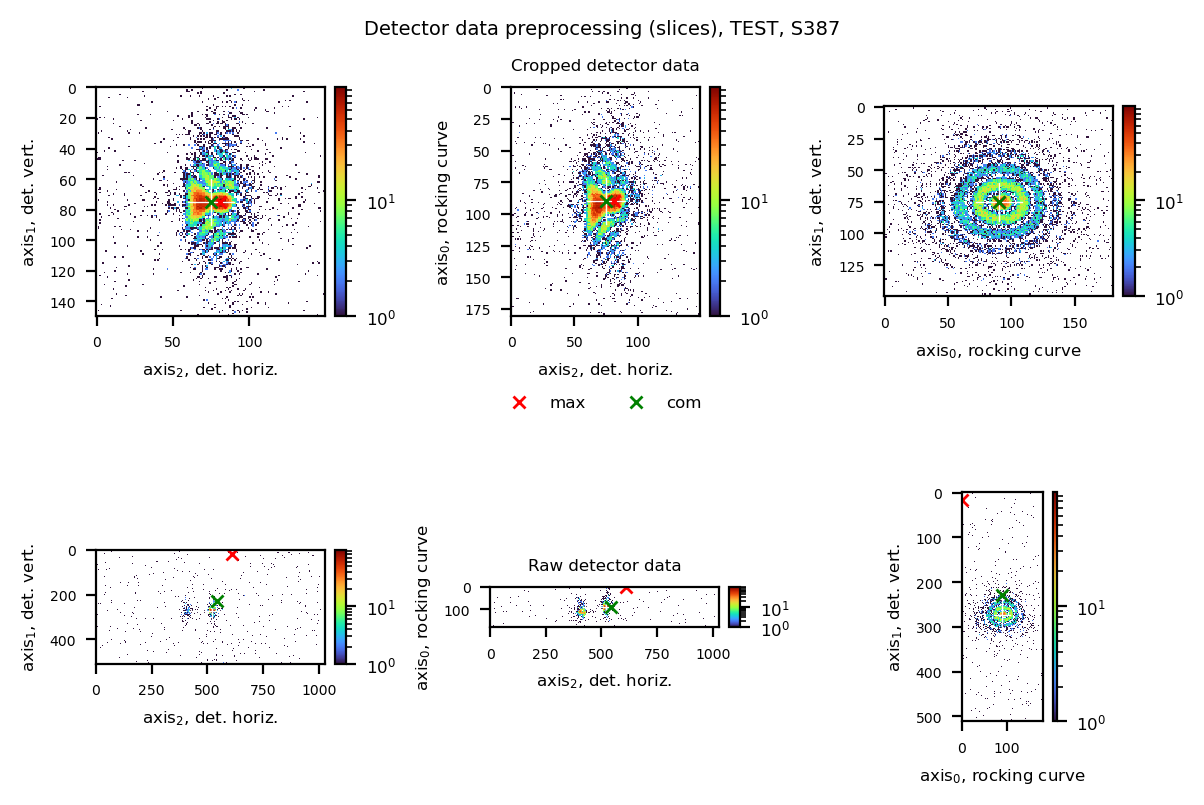

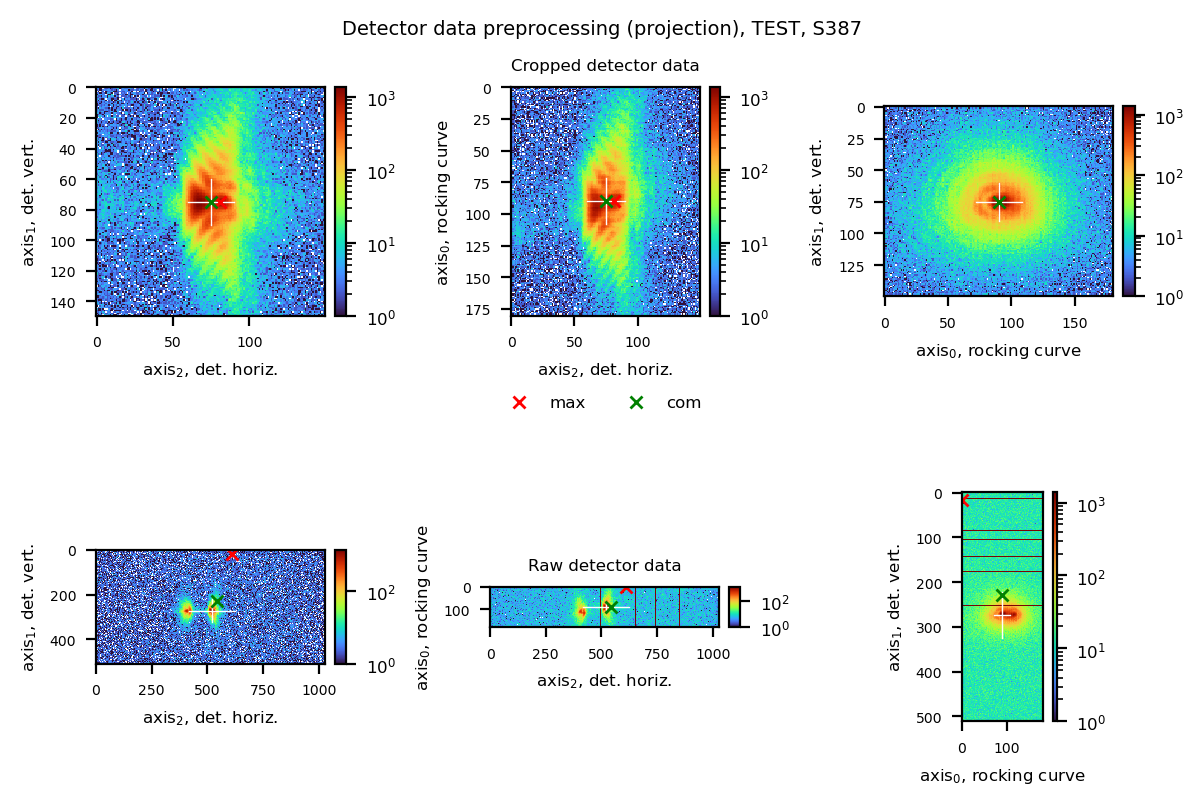

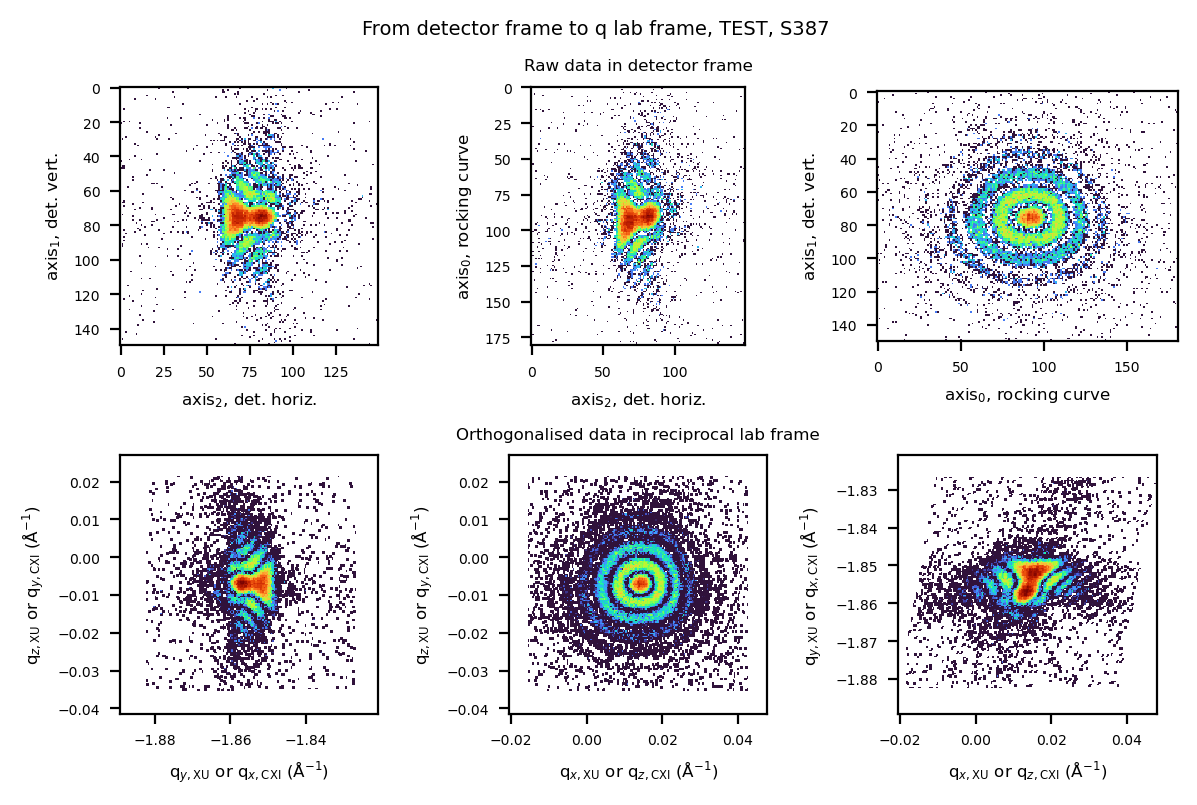

In [ ]:
bcdi_pipeline.preprocess(
    preprocess_shape=(150, 150),  # define cropped window size
    voxel_reference_methods=["max", "com", "com"],  # centring method sequence
    hot_pixel_filter=True,  # remove isolated hot pixels
    background_level=None,  # background intensity level to remove
    det_calib_params={
        "cch1": 256,  # direct beam position vertical,
        "cch2": 512,  # horizontal
        "pwidth1": 7.5e-05,  # detector pixel size in m
        "pwidth2": 7.5e-05,  # detector pixel size in m
        "distance": 1,  # sample to detector distance in m
        "tiltazimuth": 0,
        "tilt": 0,
        "detrot": 0,
        "outerangle_offset": 0.0,
    },
)

## **[PyNX](https://pynx.esrf.fr/en/latest/index.html) Phase Retrieval**
See the [pynx.cdi](https://pynx.esrf.fr/en/latest/scripts/pynx-cdi-id01.html) documentation for details on the phasing algorithms used here.  

**Algorithm recipe**

You can either:  
- provide the exact chain of algorithms.  
- or specify the number of iterations for **RAAR**, **HIO**, and **ER**.  

```python
algorithm = None  # ex: "(Sup * (ER**20)) ** 10, (Sup*(HIO**20)) ** 15, (Sup*(RAAR**20)) ** 25"
nb_raar = 500
nb_hio =  300
nb_er =  200
psf = "pseudo-voigt,1,0.05,20"
```
**Support-related parameters**
```python
support = "auto"  # ex: bcdi_pipeline.pynx_phasing_dir + "support.cxi" (path to an existing support)
```
>_Note: If strain seems to large, don't use "auto" (autocorrelation) but use "circle" or "square", in combination with "support_size"_  
```python
support_threshold = "0.15, 0.40"  # must be a string
support_update_period = 20
support_only_shrink = False
support_post_expand = None  # ex: "-1,1" or "-1,2,-1"
support_update_border_n = None
support_smooth_width_begin = 2
support_smooth_width_end = 0.5
```
**Other parameters**
```python
positivity = False
beta = 0.9  # β parameter in HIO and RAAR
detwin = True
rebin = "1, 1, 1"  # must be a string
```
**Number of Runs & Reconstructions to Keep**
```python
nb_run = 20  # total number of runs
nb_run_keep = 10  # number of reconstructions to keep
```

**Override defaults in `phase_retrieval`**

You can override any default parameter directly in the phase_retrieval method:
```python
bcdi_pipeline.phase_retrieval(nb_run=50, nb_run_keep=25)
```
If a parameter is not provided, the default value is used.

### **Phase Retrieval GUI**
You can also launch a **Graphical User Interface (GUI)** to interactively set parameters and run phase retrieval.  
```python
bcdi_pipeline.phase_retrieval_gui()
```
In that case, you can take care of the the result analysis, the selection of the best reconstructions, and the mode decomposition. Then, simply jump to the post-processing step cell.

In [ ]:
bcdi_pipeline.phase_retrieval(
    clear_former_results=True,
    nb_run=20,
    nb_run_keep=10,
    # support=bcdi_pipeline.pynx_phasing_dir + "support.cxi"
)

### **Analyse the phasing results**

This step evaluates the quality of the phase retrieval results by sorting reconstructions based on a `sorting_criterion`.  

##### **Available Sorting Criteria**
- `"mean_to_max"` → Difference between the mean of the **Gaussian fit of the amplitude histogram** and its maximum value. A **smaller difference** indicates a more homogeneous reconstruction.  
- `"sharpness"` → Sum of the amplitude within the support raised to the power of 4. **Lower values** indicate greater homogeneity.  
- `"std"` → **Standard deviation** of the amplitude.  
- `"llk"` → **Log-likelihood** of the reconstruction.  
- `"llkf"` → **Free log-likelihood** of the reconstruction.  


[INFO] Computing metrics...
[INFO] the sorted list of runs using 'mean_to_max' sorting_criterion is:
['04', '14', '13', '09', '19', '05'].
[INFO] Plotting phasing results...


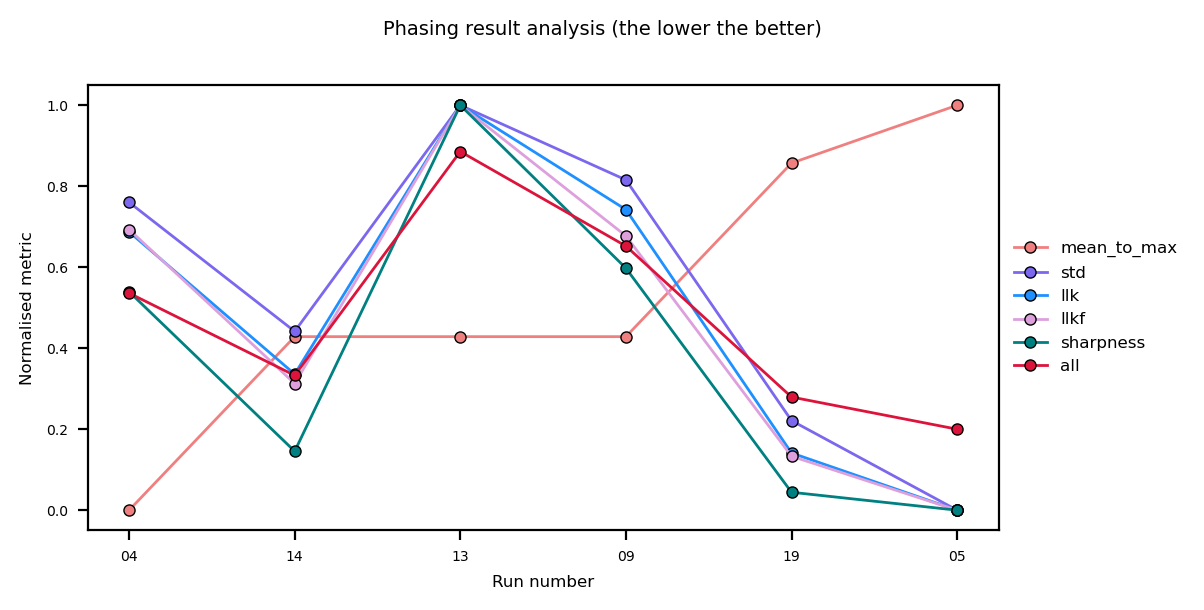

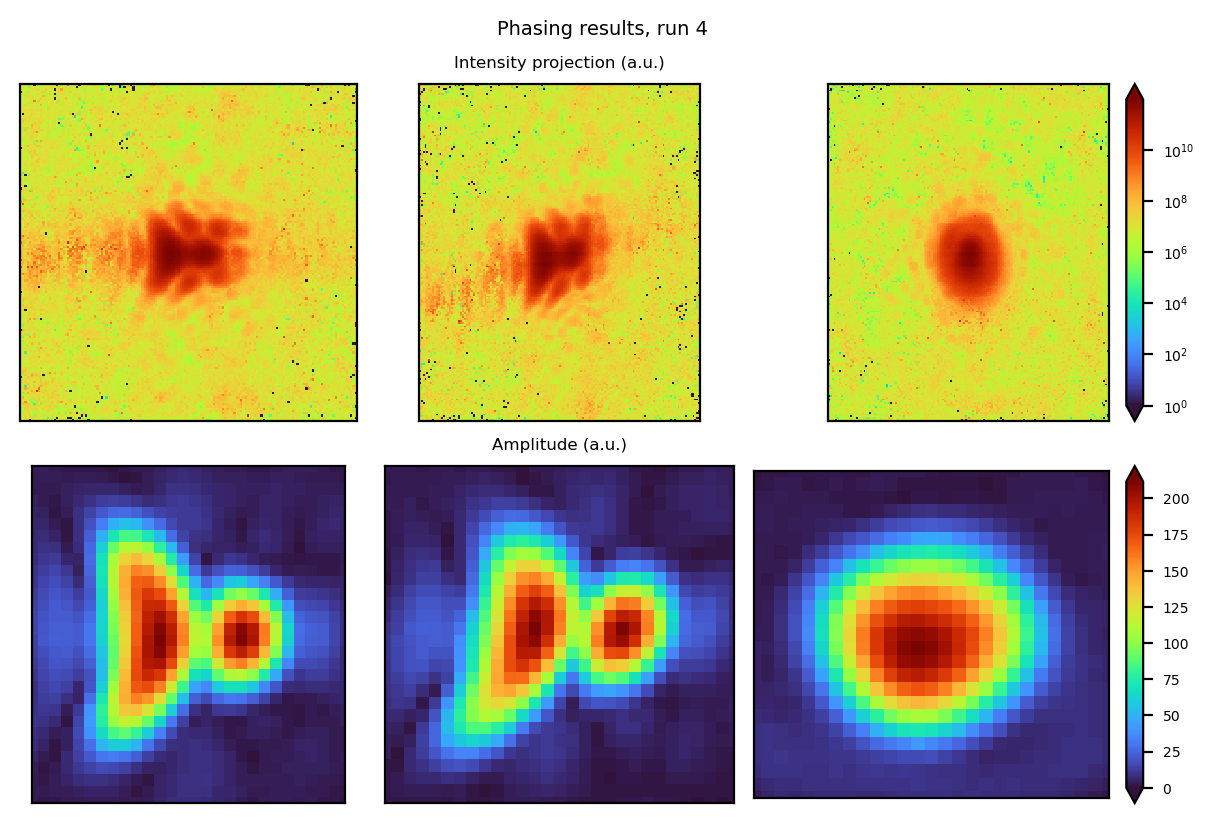

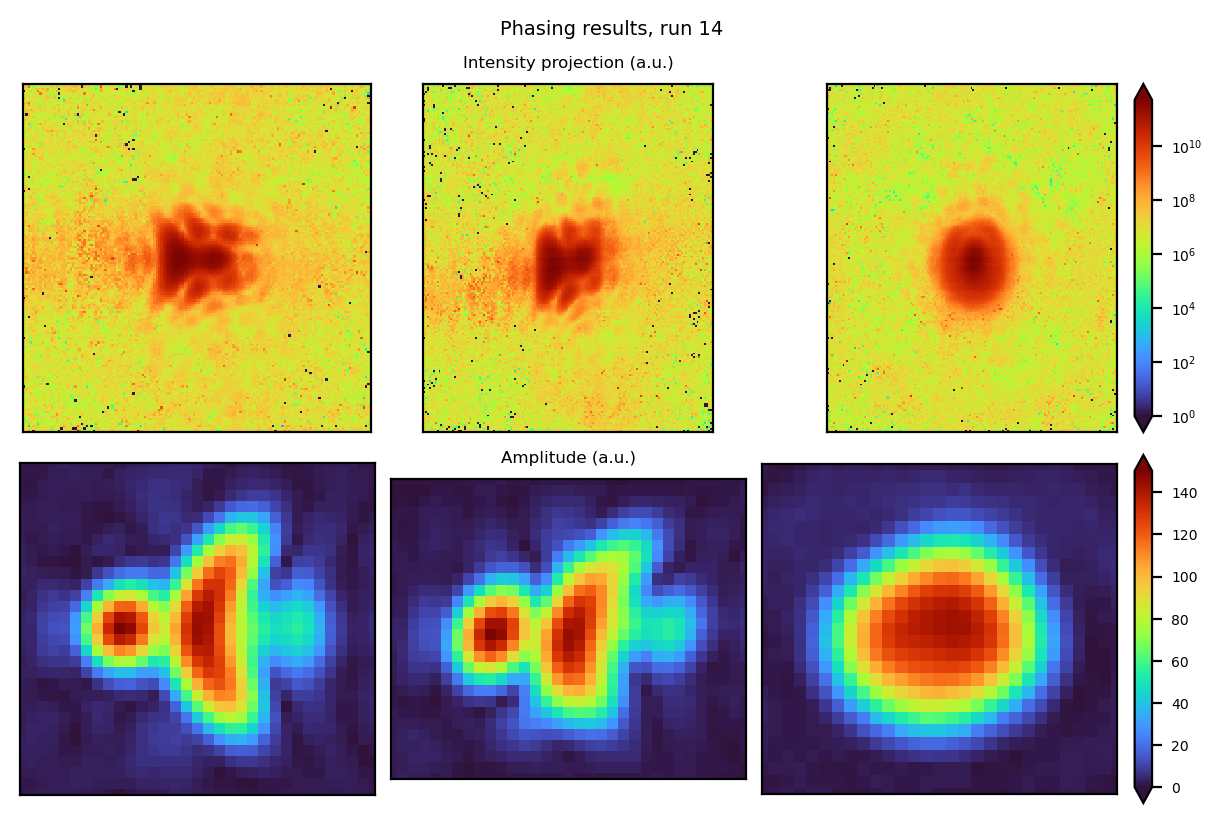

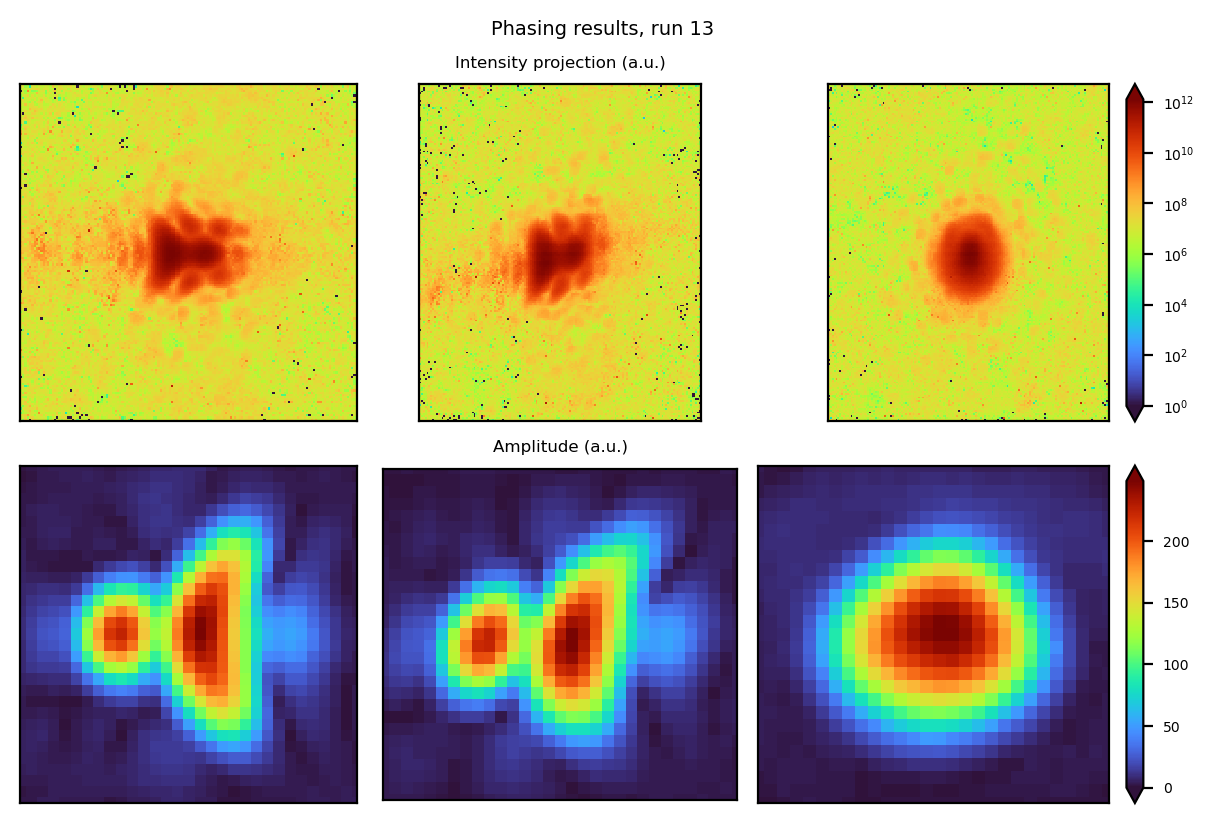

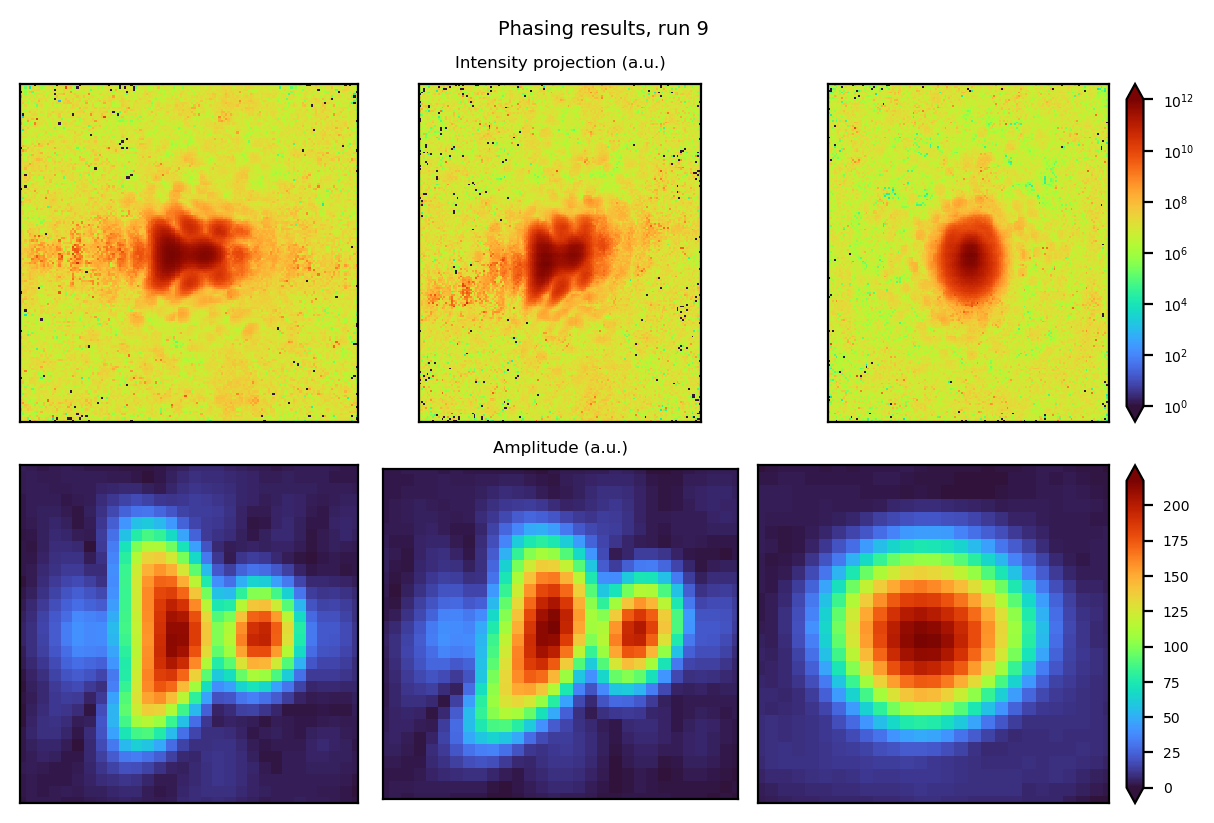

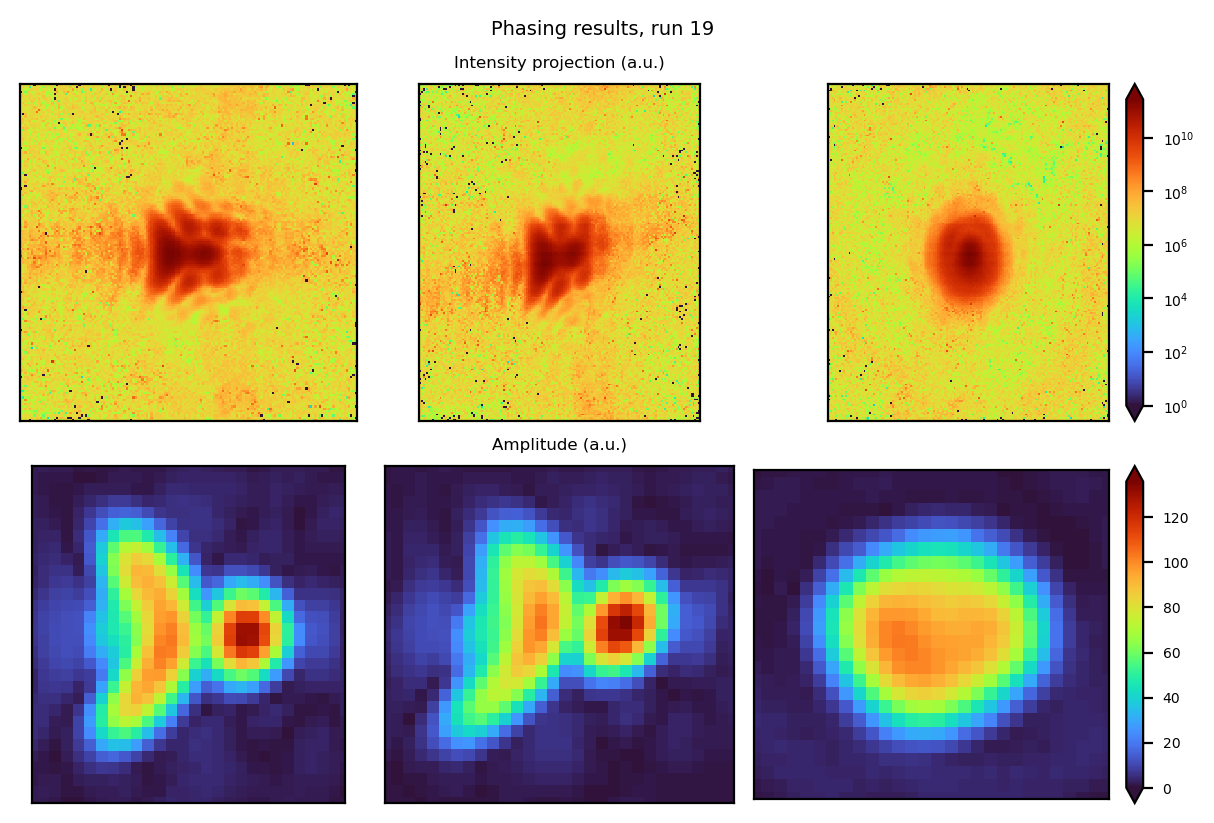

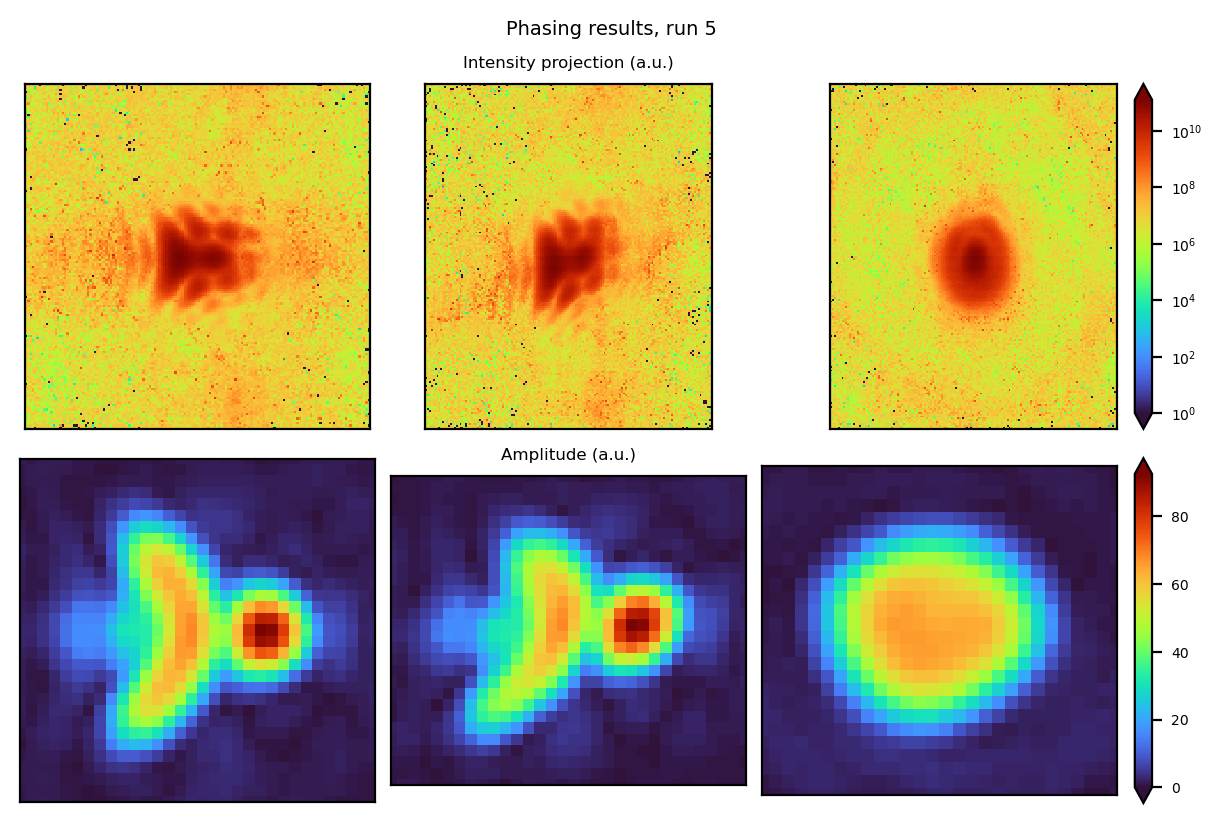

In [10]:
bcdi_pipeline.analyse_phasing_results(
    sorting_criterion="mean_to_max",  # selects the sorting method
    # Optional parameters
    # plot_phasing_results=False,  # uncomment to disable plotting
    # plot_phase=True,  # uncomment to enable phase plotting
)

### **Optionally, generate a support for further phasing attempts**  

##### **Parameters**
- `run` → set to either:  
  - `"best"` to use the best reconstruction.  
  - an **integer** corresponding to the specific run you want.  
- `output_path` → the location to save the generated support. By default, it will be saved in the `pynx_phasing` folder.  
- `fill` →  whether to fill the support if it contains holes.  
  - Default: `False`.
- `verbose` → whether to print logs and display a plot of the support.  

<!-- ```python
bcdi_pipeline.generate_support_from(run="best", output_path="path/to/save", verbose=True)
``` -->

In [ ]:
# bcdi_pipeline.generate_support_from("best", fill=False)  # uncomment to generate a support

### **Selection of the best reconstructions & mode decomposition**

You can select the best reconstructions based on a **sorting criterion** and keep a specified number of top candidates.  

##### **Parameters**
- `nb_of_best_sorted_runs` → the number of best reconstructions to keep, selected based on the `sorting_criterion` used in the `analyse_phasing_results` method above.  
- `best_runs` → instead of selecting based on sorting, you can manually specify a list of reconstruction numbers.

By default, the **best reconstructions** are automatically selected.  

Once the best candidates are chosen, `mode_decomposition` analyses them to extract dominant features.  



In [11]:
# define how many of the best candidates to keep
number_of_best_candidates: int = 2

# select the best reconstructions based on the sorting criterion
bcdi_pipeline.select_best_candidates(
    nb_of_best_sorted_runs=number_of_best_candidates
    # best_runs=[10]  # uncomment to manually select a specific run
)

# perform mode decomposition on the selected reconstructions
bcdi_pipeline.mode_decomposition()

[INFO] Best candidates selected:
['04', '14']


[INFO] 
*******************************************************************************
*                    Starting process: mode_decomposition                     *
*******************************************************************************

[INFO] 
R_match(1) = 25.063 %

[INFO] 
First mode represents 98.440 %

[INFO] Process mode_decomposition completed successfully.


## **Post-processing**

This stage includes several key operations:  
- **orthogonalisation** of the reconstructed data.  
- **phase manipulation**:  
  - phase unwrapping  
  - phase ramp removal  
- **computation of physical properties**:  
  - displacement field  
  - strain  
  - d-spacing  
- **visualisation**: Generate multiple plots for analysis.  


[INFO] 
*******************************************************************************
*                        Starting process: postprocess                        *
*******************************************************************************

[INFO] Additional parameters provided {'isosurface': 0.15, 'voxel_size': None, 'flip': False}, will update the current dictionary of parameters.
[INFO] The oversampling ratios in each direction (original frame) are axis0: 10.0, axis1: 7.5, axis2: 6.8
[WARNING] Shapes before (181, 150, 150) and after (180, 150, 150) Phase Retrieval are different.
Check out PyNX parameters (ex.: auto_center_resize (now deprecated) and roi).
[INFO] Voxel size finally used is: (10.739577192060576, 11.021013043755735, 11.371946008607427) nm in the CXI convention.
[INFO] Apodizing the complex array using blackman filter.
[INFO] Finding an isosurface estimate based on the reconstructed Bragg electron density histogram:
[INFO] Isosurface estimated at 1.0636466027284

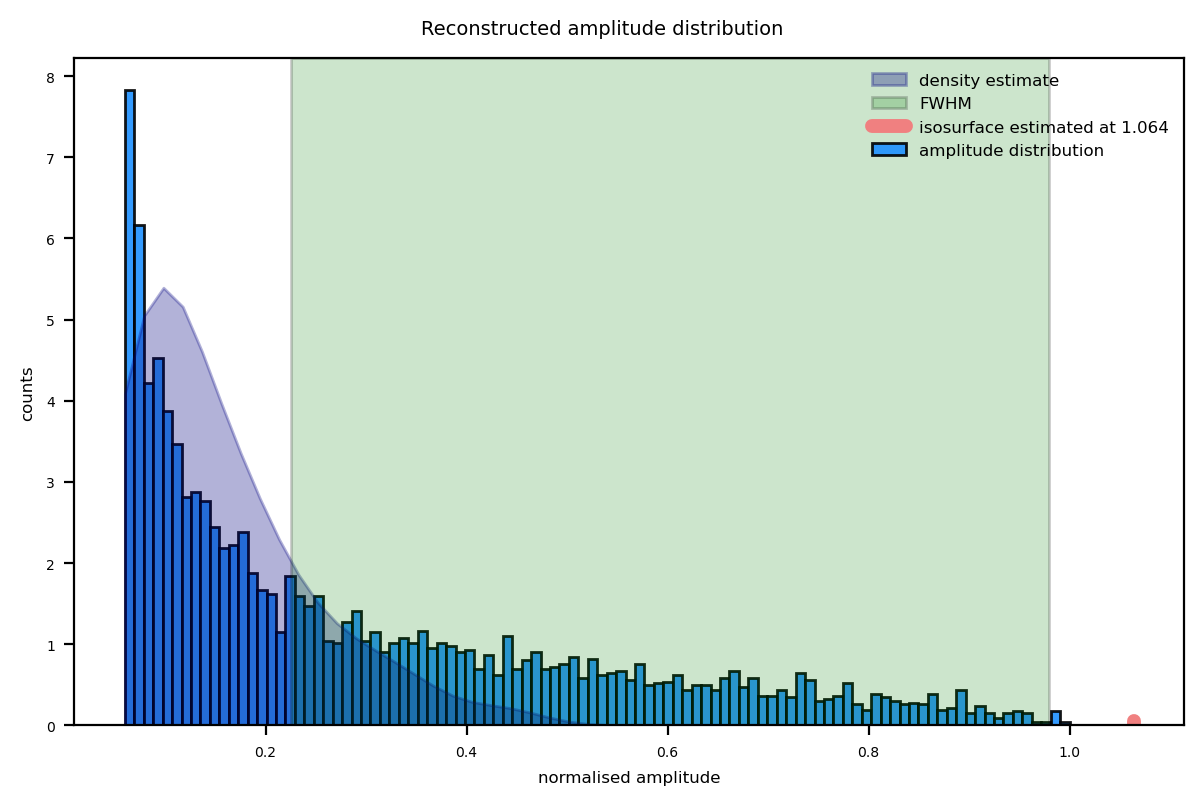

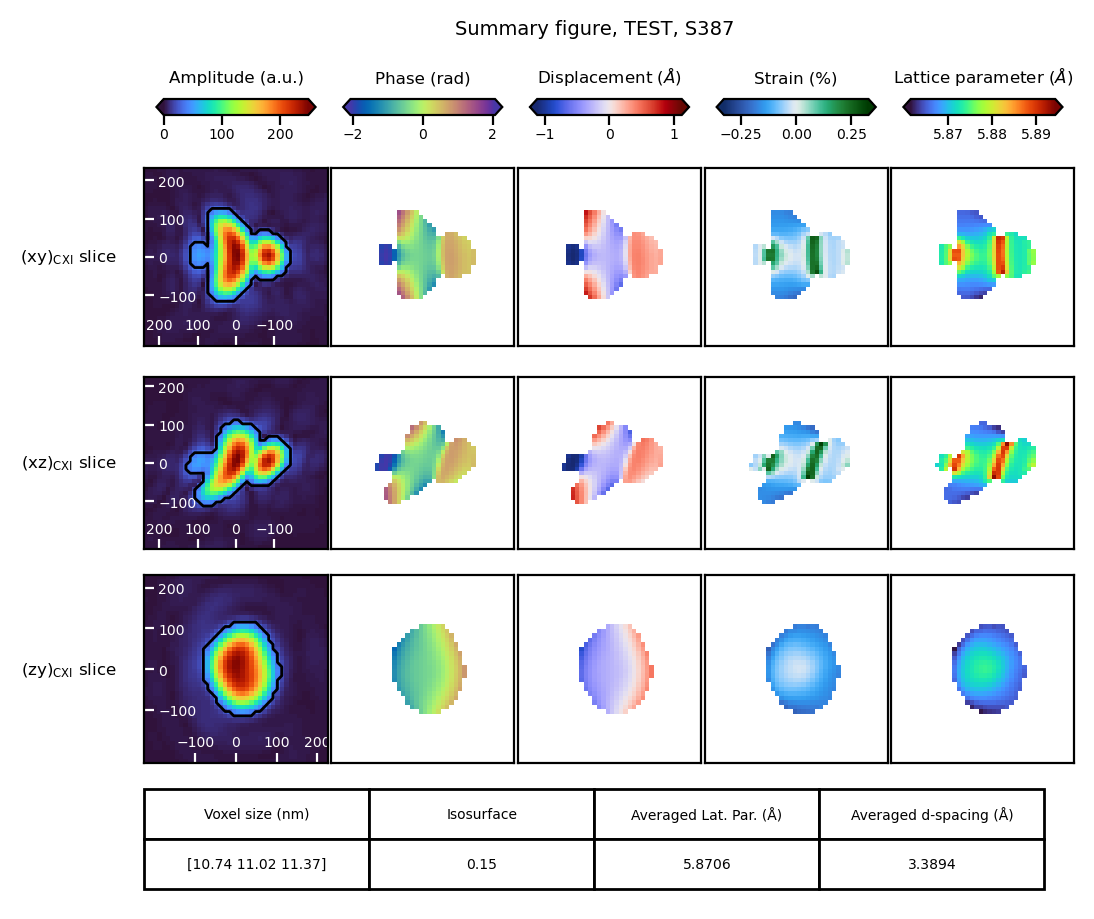

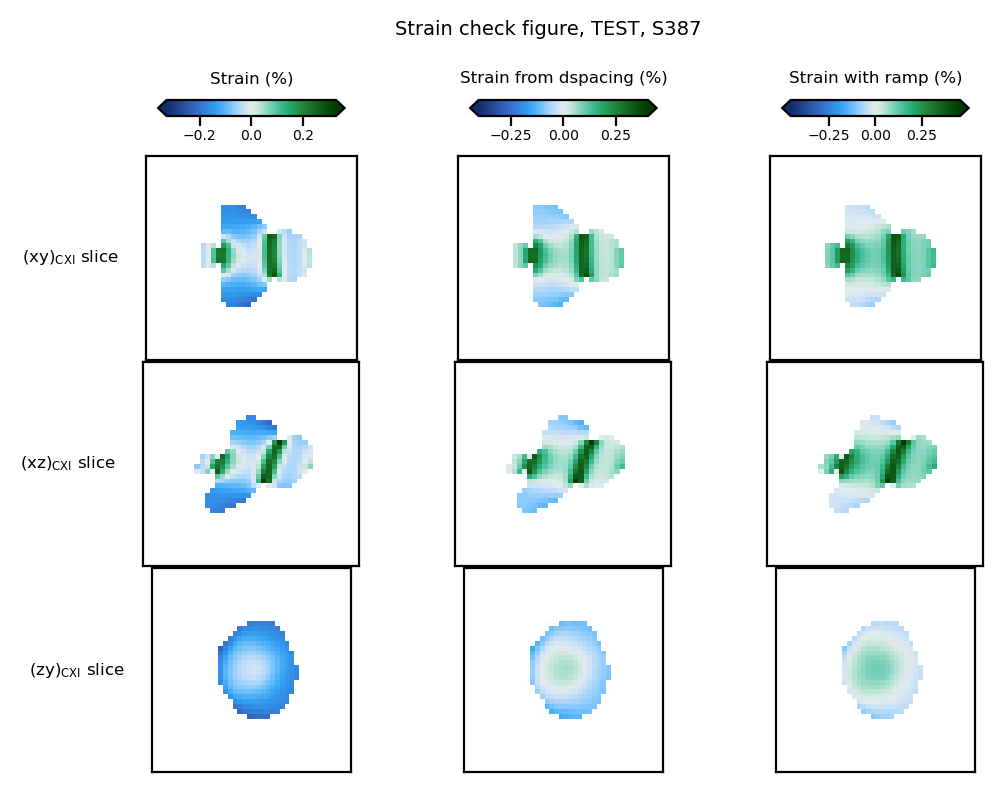

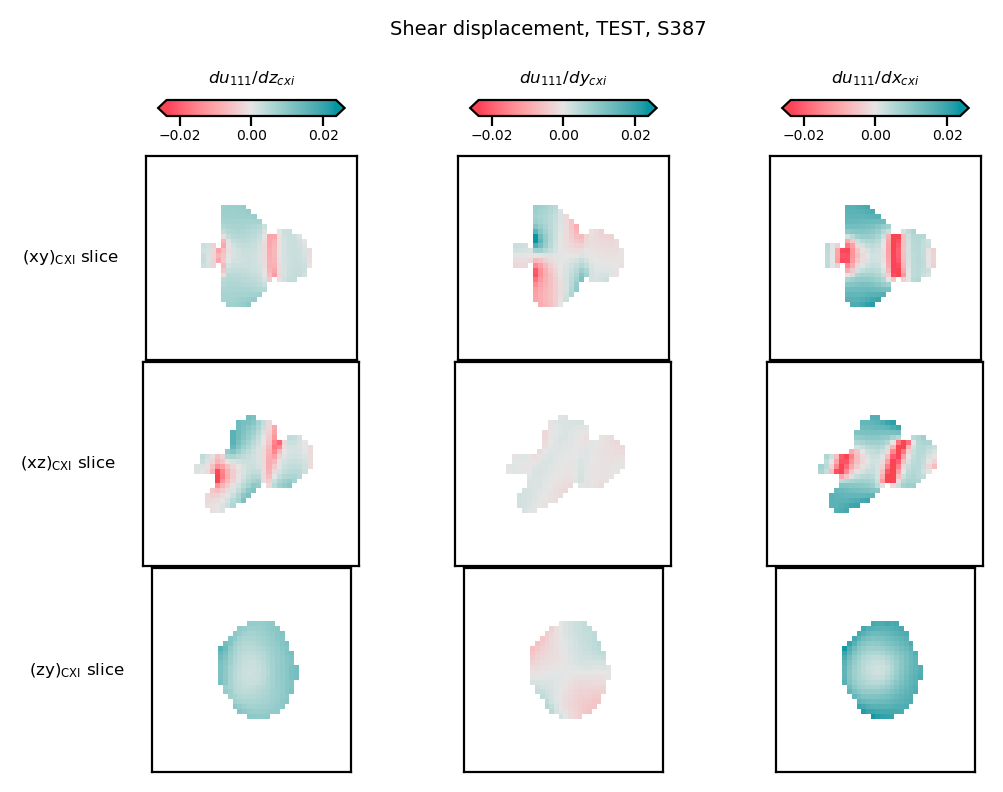

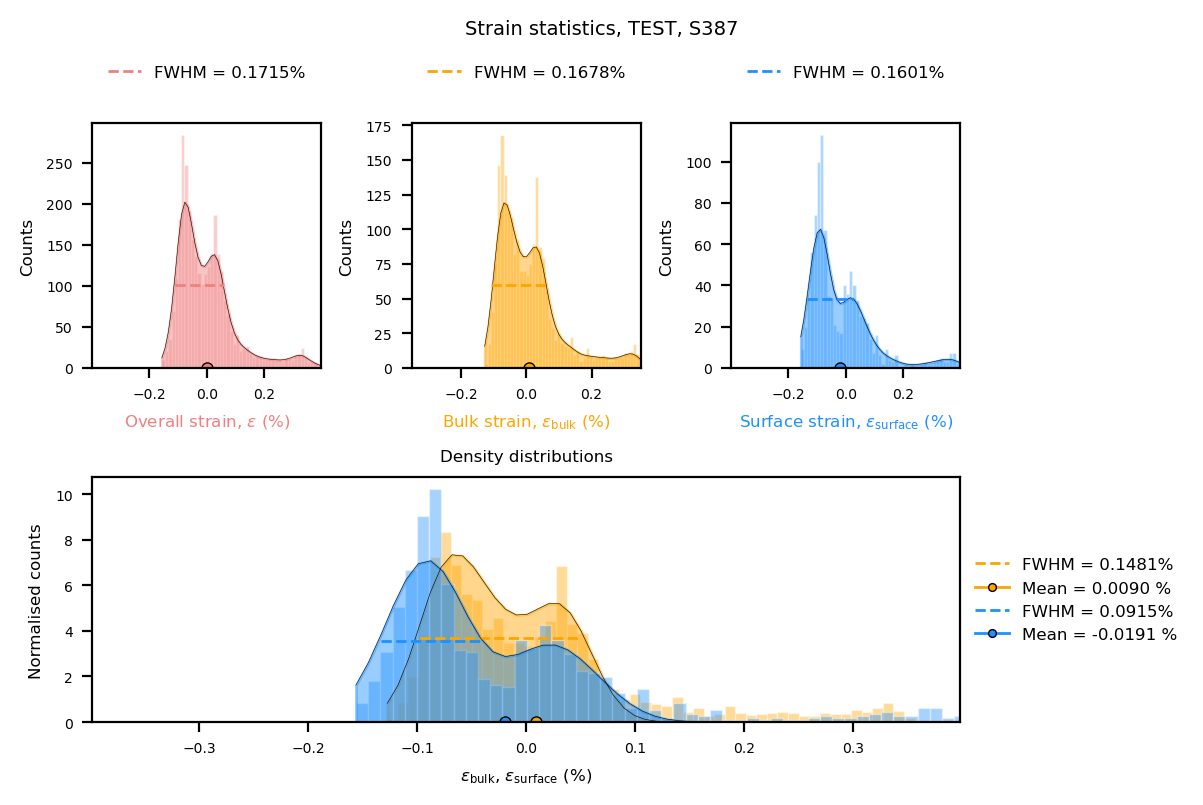

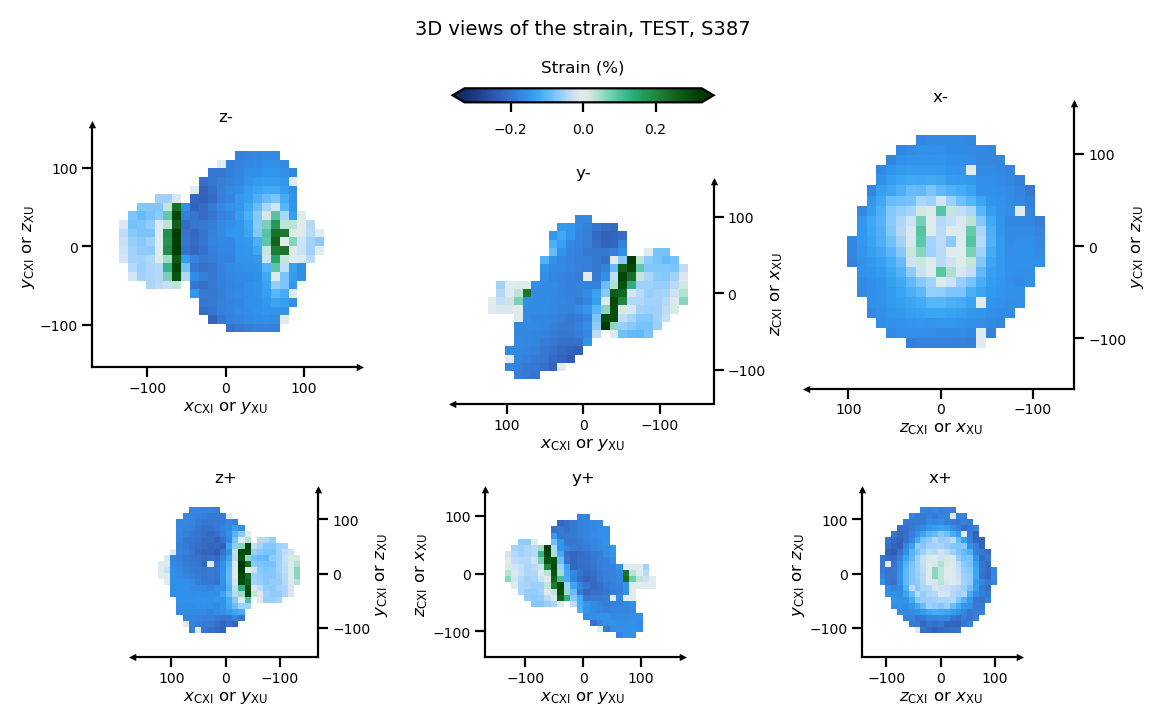

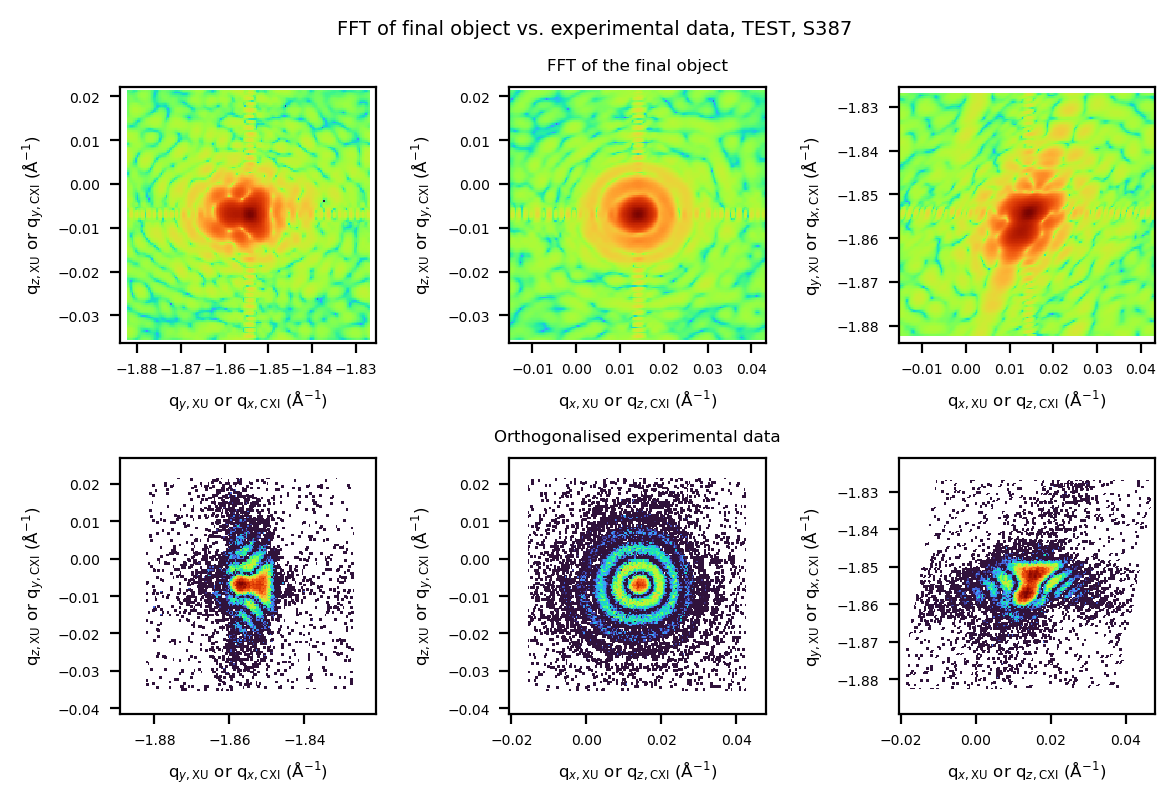

In [13]:
bcdi_pipeline.postprocess(
    isosurface=0.15,  # threshold for isosurface
    voxel_size=None,  # use default voxel size if not provided
    flip=False,  # whether to flip the reconstruction if you got the twin image (enantiomorph)
)

## **3D interactive plot**

Display an interactive 3D isosurface of the final reconstruction and explore different quantities for colouring.

What you can do
- Visualise an isosurface of the reconstructed object (amplitude / support).
- Colour the surface by different quantities: amplitude, phase, displacement, strain, d-spacing, etc.
- Interactively adjust:
    - isosurface threshold (isosurface level)
    - colormap and value range
- Rotate, zoom and pan the scene with the mouse; use the toolbar to reset view or save a screenshot.


In [14]:
bcdi_pipeline.show_3d_final_result()

## **Feedback & Issue Reporting**  

If you have **comments, suggestions, or encounter any issues**, please reach out:  

📧 **Email:** [clement.atlan@esrf.fr](mailto:clement.atlan@esrf.fr?subject=cdiutils)  
🐙 **GitHub Issues:** [Report an issue](https://github.com/clatlan/cdiutils/issues)  


## Credits
This notebook was created by Clément Atlan, ESRF, 2025. It is part of the `cdiutils` package, which provides tools for BCDI data analysis and visualisation.
If you have used this notebook or the `cdiutils` package in your research, please consider citing the package https://github.com/clatlan/cdiutils/
You'll find the citation information in the `cdiutils` package documentation.

```bibtex
@software{Atlan_Cdiutils_A_python,
author = {Atlan, Clement},
doi = {10.5281/zenodo.7656853},
license = {MIT},
title = {{Cdiutils: A python package for Bragg Coherent Diffraction Imaging processing, analysis and visualisation workflows}},
url = {https://github.com/clatlan/cdiutils},
version = {0.2.0}
}
```

